# Packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import zipfile 

# DataFrame

In [4]:
train = pd.read_csv("./train_labels.csv", dtype=str)
print(train.shape)

(220025, 2)


In [5]:
train.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


# Label Distribution %

In [6]:
y_train = train.label

(train.label.value_counts() / len(train)).to_frame().T

,0,1
label,0.594969,0.405031


# Image Samples

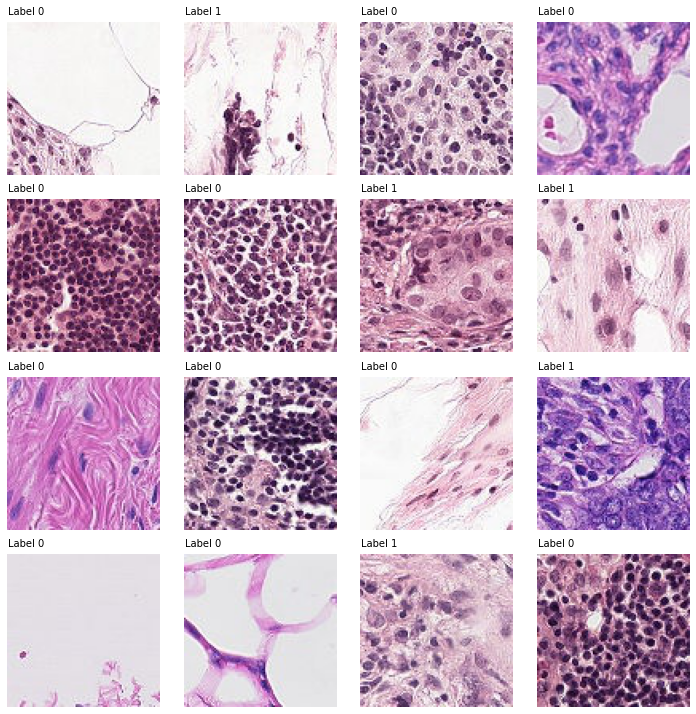

In [7]:
plt.figure(figsize=(10,10)) 

for i in range(16):
    plt.subplot(4,4,i+1)   
    img = mpimg.imread(f'./train/{train["id"][i]}.tif')
    plt.imshow(img)
    plt.text(0, -5, f'Label {train["label"][i]}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# Split and Sample Data

In [8]:
train_neg = train[train['label']=='0'].sample(10000,random_state=45)
train_pos = train[train['label']=='1'].sample(10000,random_state=45)

train_data = pd.concat([train_neg, train_pos], axis=0).reset_index(drop=True)

train = shuffle(train_data)

In [9]:
train['label'].value_counts()

1    10000
0    10000
Name: label, dtype: int64

In [10]:
def append_ext(fn):
    return fn+".tif"


train['id'] = train['id'].apply(append_ext)
train.head()

,id,label
17712,f23159bd9ed93a00fc53175471f10a749dabbba6.tif,1
11346,fb634979e824f142e0d7ae0530d8d23154a03942.tif,1
19245,f149b5e22f1b9b2e0165811d8267e6afc61b6d69.tif,1
11461,5d50fc9be2c21011fecc2e7e4dce6eea3ec5f2e2.tif,1
8389,2f8ef7aef123d3f38d242a4c062e4cfef18ae6f9.tif,0


# Generators

In [11]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=45, stratify=train.label)

print(train_df.shape)
print(valid_df.shape)

(16000, 2)
(4000, 2)


In [12]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

In [13]:
BATCH_SIZE = 64

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = './train/',
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (32,32)
)

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = './train/',
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (32,32)
)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [14]:
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS)
print(VA_STEPS)

250
63


# Network

In [15]:
base_model = tf.keras.applications.VGG16(input_shape=(32,32,3),
                                         include_top=False,
                                         weights='imagenet')

base_model.trainable = False

2022-07-31 11:41:39.689154: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-31 11:41:39.689623: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
58889256/58889256 [==============================] - 1s 0us/step


In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [17]:
cnn1 = Sequential([
    base_model,
    
    Flatten(),
    
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization (BatchN  (None, 16)               6

# Train

In [18]:
opt = tf.keras.optimizers.Adam(0.001)
cnn1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

# Train 1

In [19]:
%%time 

h1 = cnn1.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 15,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

Epoch 1/15


2022-07-31 11:41:59.802586: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-31 11:42:00.367729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/250 [============================>.] - ETA: 0s - loss: 0.6772 - accuracy: 0.6137 - auc: 0.6679

2022-07-31 11:42:10.267731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 12s 34ms/step - loss: 0.6766 - accuracy: 0.6139 - auc: 0.6684 - val_loss: 0.5754 - val_accuracy: 0.7140 - val_auc: 0.7885
Epoch 2/15
250/250 [==============================] - 5s 20ms/step - loss: 0.5838 - accuracy: 0.6893 - auc: 0.7611 - val_loss: 0.5366 - val_accuracy: 0.7338 - val_auc: 0.8110
Epoch 3/15
250/250 [==============================] - 5s 20ms/step - loss: 0.5581 - accuracy: 0.7144 - auc: 0.7856 - val_loss: 0.5323 - val_accuracy: 0.7303 - val_auc: 0.8129
Epoch 4/15
250/250 [==============================] - 5s 20ms/step - loss: 0.5384 - accuracy: 0.7292 - auc: 0.8036 - val_loss: 0.5168 - val_accuracy: 0.7475 - val_auc: 0.8247
Epoch 5/15
250/250 [==============================] - 5s 20ms/step - loss: 0.5324 - accuracy: 0.7342 - auc: 0.8111 - val_loss: 0.5203 - val_accuracy: 0.7473 - val_auc: 0.8266
Epoch 6/15
250/250 [==============================] - 5s 20ms/step - loss: 0.5256 - accuracy: 0.7389 - auc: 0.8169 - val_loss: 0.5166 -

In [20]:
history = h1.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


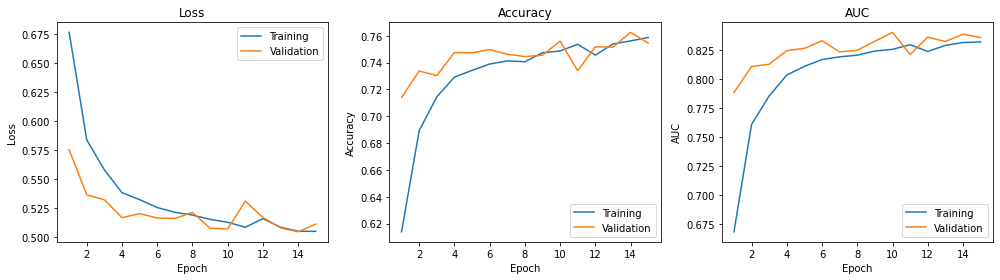

In [21]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])

plt.subplot(1,3,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()

plt.subplot(1,3,3)
plt.plot(epoch_range, history['auc'], label='Training')
plt.plot(epoch_range, history['val_auc'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Train 2

In [22]:
tf.keras.backend.set_value(cnn1.optimizer.learning_rate, 0.0001)

In [23]:
%%time 

h2 = cnn1.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 20,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

Epoch 1/20
250/250 [==============================] - 5s 21ms/step - loss: 0.4915 - accuracy: 0.7651 - auc: 0.8427 - val_loss: 0.5036 - val_accuracy: 0.7573 - val_auc: 0.8411
Epoch 2/20
250/250 [==============================] - 5s 21ms/step - loss: 0.4907 - accuracy: 0.7654 - auc: 0.8435 - val_loss: 0.5010 - val_accuracy: 0.7575 - val_auc: 0.8412
Epoch 3/20
250/250 [==============================] - 5s 21ms/step - loss: 0.4857 - accuracy: 0.7686 - auc: 0.8470 - val_loss: 0.4993 - val_accuracy: 0.7603 - val_auc: 0.8419
Epoch 4/20
250/250 [==============================] - 5s 20ms/step - loss: 0.4862 - accuracy: 0.7688 - auc: 0.8466 - val_loss: 0.4993 - val_accuracy: 0.7570 - val_auc: 0.8408
Epoch 5/20
250/250 [==============================] - 5s 20ms/step - loss: 0.4848 - accuracy: 0.7703 - auc: 0.8476 - val_loss: 0.4997 - val_accuracy: 0.7580 - val_auc: 0.8418
Epoch 6/20
250/250 [==============================] - 5s 20ms/step - loss: 0.4847 - accuracy: 0.7700 - auc: 0.8479 - val_loss

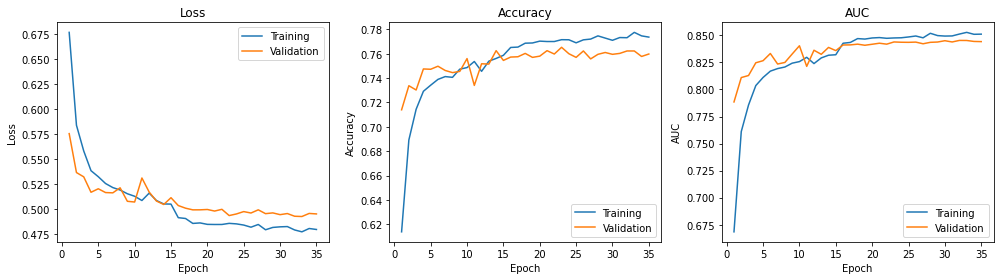

In [24]:
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,3,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,3,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.subplot(1,3,3)
plt.plot(epoch_range, history['auc'], label='Training')
plt.plot(epoch_range, history['val_auc'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()
plt.tight_layout()
plt.show()

# Train 3

In [25]:
tf.keras.backend.set_value(cnn1.optimizer.learning_rate, 0.00001)

In [ ]:
%%time 

h3 = cnn1.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 30,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

Epoch 1/30
250/250 [==============================] - 5s 20ms/step - loss: 0.4781 - accuracy: 0.7773 - auc: 0.8518 - val_loss: 0.4942 - val_accuracy: 0.7618 - val_auc: 0.8448
Epoch 2/30
250/250 [==============================] - 5s 20ms/step - loss: 0.4791 - accuracy: 0.7769 - auc: 0.8518 - val_loss: 0.4945 - val_accuracy: 0.7588 - val_auc: 0.8447
Epoch 3/30
250/250 [==============================] - 5s 20ms/step - loss: 0.4743 - accuracy: 0.7757 - auc: 0.8548 - val_loss: 0.4942 - val_accuracy: 0.7590 - val_auc: 0.8447
Epoch 4/30
250/250 [==============================] - 5s 20ms/step - loss: 0.4771 - accuracy: 0.7768 - auc: 0.8536 - val_loss: 0.4942 - val_accuracy: 0.7588 - val_auc: 0.8449
Epoch 5/30
250/250 [==============================] - 5s 21ms/step - loss: 0.4779 - accuracy: 0.7748 - auc: 0.8535 - val_loss: 0.4941 - val_accuracy: 0.7578 - val_auc: 0.8449
Epoch 6/30
250/250 [==============================] - 5s 20ms/step - loss: 0.4786 - accuracy: 0.7761 - auc: 0.8519 - val_loss

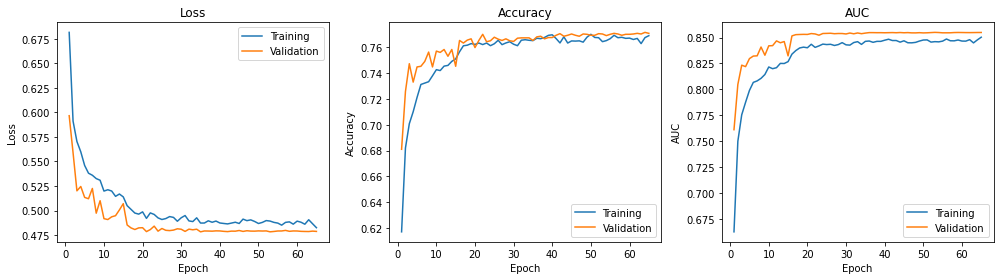

In [25]:
for k in history.keys():
    history[k] += h3.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,3,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,3,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.subplot(1,3,3)
plt.plot(epoch_range, history['auc'], label='Training')
plt.plot(epoch_range, history['val_auc'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()
plt.tight_layout()
plt.show()